In [1]:
from collections import Counter
import numpy as np
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from unicodedata import normalize
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Dense,Concatenate, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D,Dropout, Add,Embedding
from keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
MAX_URL_LEN_CHAR = 100
MAX_URL_LEN_WORD = 100
MAX_WORD_LEN = 20
k = 36
num_filters = 256
batch_size = 48

In [3]:
# conn = sqlite3.connect('casino.db')

# df = pd.read_sql('select * from web_pages',conn)
# df.drop(columns=["id","url","html","screenshot"],inplace=True)



# Load dmoz and porn datasets

In [4]:
df = pd.read_csv('./datasets/dmoz.csv')
df_porn_casino = pd.read_csv('./porn_casino_links.csv')
df_malicious = pd.read_csv('malicious_links.csv')
df = pd.concat([df,df_malicious,df_porn_casino],ignore_index=True)
df['category'] = df['category'].replace('Arts', 'Benign')
df['category'] = df['category'].replace('Business', 'Benign')
df['category'] = df['category'].replace('Computers', 'Benign')
df['category'] = df['category'].replace('Games', 'Benign')
df['category'] = df['category'].replace('Health', 'Benign')
df['category'] = df['category'].replace('Kids', 'Benign')
df['category'] = df['category'].replace('Science', 'Benign')
df['category'] = df['category'].replace('Reference', 'Benign')
df['category'] = df['category'].replace('Sports', 'Benign')
df['category'] = df['category'].replace('Society', 'Benign')
df['category'] = df['category'].replace('Recreation', 'Benign')
df['category'] = df['category'].replace('Shopping', 'Benign')
df['category'] = df['category'].replace('Home', 'Benign')
df['category'] = df['category'].replace('News', 'Benign')

#drop Nans
df = df.dropna()
df = df.drop_duplicates()
# df_benign = df[df['category'] == 'Benign']
# df_benign = df_benign.sample(n=450000, random_state=44)
# df_adult = df[df['category'] == "Adult"]
# df = pd.concat([df_benign,df_malicious,df_adult],ignore_index=True)
df['url'] = df['url'].apply(lambda word: normalize('NFKD', word))



# # shuffle the data
df = df.sample(frac=1, random_state=44).reset_index(drop=True)
# df = df[:int(0.3*len(df))]
print(len(df))


2422696


In [5]:
df.groupby('category').count()

,url
category,
Adult,860006
Benign,1480191
Malicious,82499


# Load malicious links dataset and merge with main df

In [6]:

classes = sorted(list(set(df.category.values)))
num_classes = len(classes)
print(num_classes)

class_to_int = { word:i for i,word in enumerate(classes)}
int_to_class = {i:word for i,word in enumerate(classes)}

encode = lambda class_: class_to_int[class_]

df['category'] = df['category'].apply(encode)

3


In [7]:
int_to_class

{0: 'Adult', 1: 'Benign', 2: 'Malicious'}

In [8]:
train_split = int(0.8 * len(df))
x_train = df.url.values[:train_split]
y_train = df.category.values[:train_split]

x_test = df.url.values[train_split:train_split+ int(0.15 * len(df)) ]
y_test =  df.category.values[train_split:train_split+ int(0.15 * len(df))]

x_val = df.url.values[train_split+ int(0.15 * len(df)): ]
y_val =  df.category.values[train_split+ int(0.15 * len(df)): ]
print("for training: " + str(len(x_train))+ " for testing: " + str(len(x_test))+ " for validating: " + str(len(x_val)))
print(x_train[0],y_train[0])

for training: 1938156 for testing: 363404 for validating: 121136
http://www.fortunecity.com/meltingpot/togo/1192/ 1


In [9]:
df[train_split+ int(0.15 * len(df)): ].groupby('category').count()

,url
category,
0,42918
1,74124
2,4094


# Tokenizers and functions

## Character level tokenizer

In [10]:
# Character tokenization
char_tokenizer = Tokenizer(char_level=True, oov_token='<OOV>')
char_tokenizer.fit_on_texts(x_train)


In [11]:
def text_to_word_sequence(
    input_text,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
):
    
    if lower:
        input_text = input_text.lower()

    translate_dict = {c: split for c in filters}
    translate_map = str.maketrans(translate_dict)
    input_text = input_text.translate(translate_map)

    seq = input_text.split(split)
    return [i for i in seq if i]

### Word level tokenizer

#### Calculate number of words which appear more than once

In [12]:
def frequency_calculation():
    word_sequences = [text_to_word_sequence(sentence) for sentence in x_train]
    all_words_concat = [item for sublist in word_sequences for item in sublist]
    freq_dict_words = Counter(all_words_concat)
    
    low_freq_words_count = 0
    for key in freq_dict_words:
        if freq_dict_words[key] == 1:
            low_freq_words_count += 1
    
    high_freq_word_count = int(len(freq_dict_words) * (1-(low_freq_words_count/len(freq_dict_words))))
    print(high_freq_word_count)
    return high_freq_word_count

#### Url into sequence of word ids

In [13]:
high_freq_word_count = 100000
high_freq_word_count

100000

In [14]:
word_tokenizer = Tokenizer(oov_token='<OOV>'
                           ,num_words=high_freq_word_count
                          )
word_tokenizer.fit_on_texts(x_train)

## define DataGenerator for preprocessing(tokenizing and padding) inputs on the fly

In [15]:
class DataGenerator(Sequence):
    def __init__(self, urls, labels, batch_size, char_tokenizer, word_tokenizer):
        self.urls = urls
        self.labels = labels
        self.batch_size = batch_size
        self.char_tokenizer = char_tokenizer
        self.word_tokenizer = word_tokenizer
        self.indexes = np.arange(len(urls))
    
    def __len__(self):
        return int(np.ceil(len(self.urls) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_urls = [self.urls[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        char_input_data = self._preprocess_char_input(batch_urls)
        word_input_data = self._preprocess_word_input(batch_urls)
        word_char_input_data = self._preprocess_word_char_input(batch_urls)
        
        return [char_input_data, word_input_data, word_char_input_data], np.array(batch_labels)
    
    def _preprocess_char_input(self, urls):
        char_sequences = self.char_tokenizer.texts_to_sequences(urls)
        return pad_sequences(char_sequences, maxlen=MAX_URL_LEN_CHAR, padding='post',truncating='post')
    
    def _preprocess_word_input(self, urls):
        word_sequences = self.word_tokenizer.texts_to_sequences(urls)
        return pad_sequences(word_sequences, maxlen=MAX_URL_LEN_WORD, padding='post',truncating='post')
    
    def _preprocess_word_char_input(self, urls):
        sentences_splitted = [text_to_word_sequence(sentence) for sentence in urls]
    
        for i in range(len(sentences_splitted)):
            if len(sentences_splitted[i])>MAX_URL_LEN_CHAR:
                sentences_splitted[i] = sentences_splitted[i][:MAX_URL_LEN_CHAR]
            else:
                while len(sentences_splitted[i])<MAX_URL_LEN_CHAR:
                    sentences_splitted[i].append('<OOV>')
            
        words_splitted = [[word.split() for word in sentence] for sentence in sentences_splitted]

        word_char_sequences = []
        
        for sentence in words_splitted:
            sentence_tokenized = []
            for i in range(len(sentence)):
                word = self.char_tokenizer.texts_to_sequences(sentence[i])
                word_char_padded = pad_sequences(word,maxlen=MAX_WORD_LEN,padding='post',truncating='post')
                sentence_tokenized.append(word_char_padded)
            word_char_sequences.append(sentence_tokenized)
        try:
            word_char_sequences = np.array(word_char_sequences)
        except:
            print(urls)
        try:
            word_char_sequences = word_char_sequences.reshape(word_char_sequences.shape[0],word_char_sequences.shape[1],word_char_sequences.shape[-1])
        except:
            print(urls)
        return word_char_sequences


    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


In [16]:
training_generator = DataGenerator(x_train, y_train, batch_size, char_tokenizer, word_tokenizer)
test_generator = DataGenerator(x_test, y_test, batch_size, char_tokenizer, word_tokenizer)
val_generator = DataGenerator(x_val, y_val, batch_size, char_tokenizer, word_tokenizer)

# Character level CNN

### Character embedding

In [17]:
char_input = Input((MAX_URL_LEN_CHAR,))

# Embedding layer
char_embedding = Embedding(input_dim=len(char_tokenizer.word_index) + 1, output_dim=k, input_length=MAX_URL_LEN_CHAR)(char_input)
char_embedding = tf.expand_dims(char_embedding, -1)  # Add channel dimension

# CNN Block

In [18]:
# Convolution and pooling for character-level
# h = 3
conv_3_char = Conv2D(num_filters, (3, k), activation='relu')(char_embedding)
conv_3_char = BatchNormalization()(conv_3_char)  # Batch normalization after convolution
conv_3_char = Activation('relu')(conv_3_char) 
conv_3_char = MaxPooling2D((2, 1), strides=(2, 1))(conv_3_char)
# h = 4
conv_4_char = Conv2D(num_filters, (4, k), activation='relu')(char_embedding)
conv_4_char = BatchNormalization()(conv_4_char)  # Batch normalization after convolution
conv_4_char = Activation('relu')(conv_4_char) 
conv_4_char = MaxPooling2D((2, 1), strides=(2, 1))(conv_4_char)
# h = 5
conv_5_char = Conv2D(num_filters, (5, k), activation='relu')(char_embedding)
conv_5_char = BatchNormalization()(conv_5_char)  # Batch normalization after convolution
conv_5_char = Activation('relu')(conv_5_char) 
conv_5_char = MaxPooling2D((2, 1), strides=(2, 1))(conv_5_char)
# h = 6
conv_6_char = Conv2D(num_filters, (6, k), activation='relu')(char_embedding)
conv_6_char = BatchNormalization()(conv_6_char)  # Batch normalization after convolution
conv_6_char = Activation('relu')(conv_6_char) 
conv_6_char = MaxPooling2D((2, 1), strides=(2, 1))(conv_6_char)

### Fully connected layer

In [19]:
#concatenate all convolutional layer outputs
concatenated = Concatenate(axis=1)([conv_3_char,conv_4_char,conv_5_char,conv_6_char])
flattened = Flatten()(concatenated)

# feed concatenated conv layers to fully conected layer
dense_char = Dense(512,activation='relu',kernel_regularizer=l2(0.01))(flattened)
dropout = Dropout(0.5)(dense_char)

# Word-level Block

##### reduce the size of word_index to reduce embeddings

In [20]:
most_freq_words = dict(list(word_tokenizer.word_index.items())[:high_freq_word_count])
most_freq_words[word_tokenizer.oov_token] = high_freq_word_count + 1  # Add OOV token index manually

# Step 3: Use the length of this new word index for the embedding layer
input_dim = len(most_freq_words) + 1
# input_dim = len(word_tokenizer.word_index)+1

##### word embedding

In [21]:
word_input = Input(shape=(MAX_URL_LEN_WORD,))

# Embedding layer
word_embedding = Embedding(input_dim=input_dim, output_dim=k, input_length=MAX_URL_LEN_WORD)(word_input)

word_embedding.shape

TensorShape([None, 100, 36])

##### char embedding 2

In [22]:
word_char_input = Input(shape=(MAX_URL_LEN_CHAR,MAX_WORD_LEN))

# Embedding layer
word_char_embedding = Embedding(input_dim=len(char_tokenizer.word_index) + 1, output_dim=k, input_length=MAX_URL_LEN_CHAR)(word_char_input)
word_char_embedding.shape

TensorShape([None, 100, 20, 36])

##### Sum over characters

In [23]:
pooled_layer = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, axis=2))(word_char_embedding)
pooled_layer.shape

TensorShape([None, 100, 36])

#### Element-wise Addition

In [24]:
addition_layer = Add()([pooled_layer, word_embedding])
addition_layer = tf.expand_dims(addition_layer,-1)

addition_layer.shape

TensorShape([None, 100, 36, 1])

## Word-level CNN Block

In [25]:
# Convolution and pooling for word-level
# h = 3
conv_3_word = Conv2D(num_filters, (3, k))(addition_layer)
conv_3_word = BatchNormalization()(conv_3_word)  # Batch normalization after convolution
conv_3_word = Activation('relu')(conv_3_word) 
conv_3_word = MaxPooling2D((2, 1), strides=(2, 1))(conv_3_word)
# h = 4
conv_4_word = Conv2D(num_filters, (4, k), activation='relu')(addition_layer)
conv_4_word = BatchNormalization()(conv_4_word)  # Batch normalization after convolution
conv_4_word = Activation('relu')(conv_4_word) 
conv_4_word = MaxPooling2D((2, 1), strides=(2, 1))(conv_4_word)
# h = 5
conv_5_word = Conv2D(num_filters, (5, k), activation='relu')(addition_layer)
conv_5_word = BatchNormalization()(conv_5_word)  # Batch normalization after convolution
conv_5_word = Activation('relu')(conv_5_word) 
conv_5_word = MaxPooling2D((2, 1), strides=(2, 1))(conv_5_word)
# h = 6
conv_6_word = Conv2D(num_filters, (6, k), activation='relu')(addition_layer)
conv_6_word = BatchNormalization()(conv_6_word)  # Batch normalization after convolution
conv_6_word = Activation('relu')(conv_6_word) 
conv_6_word = MaxPooling2D((2, 1), strides=(2, 1))(conv_6_word)

## Word level fully connected layer

In [26]:
#concatenate all convolutional layer outputs
concatenated_word = Concatenate(axis=1)([conv_3_word,conv_4_word,conv_5_word,conv_6_word])
flattened_word = Flatten()(concatenated_word)

# feed concatenated conv layers to fully conected layer
dense_word = Dense(512,activation='relu',kernel_regularizer=l2(0.01))(flattened_word)
dropout_word = Dropout(0.5)(dense_word)
dropout_word.shape

TensorShape([None, 512])

## concatenate outputs of char-level and word-level blocks

In [27]:
concatenate_all = Concatenate()([dropout,dropout_word])
concatenate_all.shape

TensorShape([None, 1024])

# last fully connected layers

In [28]:
fc_1 = Dense(512,activation='relu',kernel_regularizer=l2(0.01))(concatenate_all)
dropout_fc_1 = Dropout(0.6)(fc_1)

fc_2 = Dense(256,activation='relu',kernel_regularizer=l2(0.01))(dropout_fc_1)
dropout_fc_2 = Dropout(0.5)(fc_2)

fc_3 = Dense(128,activation='relu',kernel_regularizer=l2(0.01))(dropout_fc_2)
dropout_fc_3 = Dropout(0.5)(fc_3)

# output layer with softmax
output = Dense(num_classes, activation='softmax')(dropout_fc_3)

# Model compile

In [29]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model_low_embed.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

In [30]:
model = Model(inputs=[char_input, word_input, word_char_input],outputs=output)
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 20)]    0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 20, 36)  3420        input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
______________________________________________________________________________________________

In [31]:
history = model.fit(
    training_generator,
    # [char_input_data, word_input_data, word_char_input_data],
    # y_train,
    validation_data=val_generator,
    epochs=3,
    # validation_freq=2,
    callbacks=[checkpoint, early_stopping])

Epoch 1/3
40379/40379 [==============================] - 2449s 60ms/step - loss: 0.2502 - accuracy: 0.9643 - val_loss: 0.2254 - val_accuracy: 0.9558


C:\Users\warfa\.conda\envs\AI\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/3
40379/40379 [==============================] - 2356s 58ms/step - loss: 0.1890 - accuracy: 0.9700 - val_loss: 0.1616 - val_accuracy: 0.9734
Epoch 3/3
40379/40379 [==============================] - 2434s 60ms/step - loss: 0.1813 - accuracy: 0.9711 - val_loss: 0.1608 - val_accuracy: 0.9741


In [69]:
import io
import json
char_tokenizer_json = char_tokenizer.to_json()
word_tokenizer_json = word_tokenizer.to_json()
with io.open('./tokenizers/char_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(char_tokenizer_json, ensure_ascii=False))
with io.open('./tokenizers/word_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(word_tokenizer_json, ensure_ascii=False))


In [18]:
def load_model(model_name):
    model = tf.keras.models.load_model(model_name)
    return model

In [24]:
model = load_model('best_model.h5')

In [25]:
decode = lambda int_: int_to_class[int_]

In [ ]:
preds = model.evaluate(test_generator)

In [ ]:
def predict(urls):
    
model.predict()

In [33]:
length = len(test_generator)

In [34]:
y_true = []
y_pred = []
for i,batch in enumerate(test_generator):
    urls, labels = batch
    y_true.extend(labels)
    predictions = model.predict(urls)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())
    print(f"Progress: {i}/{length}", end='\r')

y_true = np.array(y_true)
y_pred = np.array(y_pred)

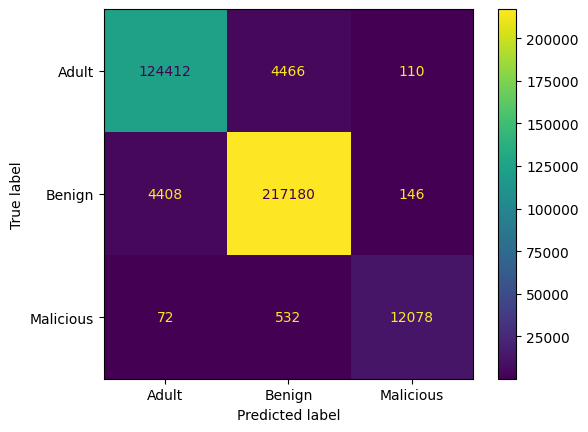

In [35]:
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
# Confusion Matrix
class_values = list(int_to_class.values())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_values)
disp.plot()
plt.show()

In [36]:
print(f"precision weighted: {precision_weighted}\nprecision micro: {precision_micro} ")
print(f'recall weighted: {recall_weighted}\nrecall micro: {recall_micro} ')
print(f'f1 weighted: {f1_weighted}\nf1 micro: {f1_micro}')

precision weighted: 0.9732128107661041
precision micro: 0.9732143839913705 
recall weighted: 0.9732143839913705
recall micro: 0.9732143839913705 
f1 weighted: 0.9732064301821027
f1 micro: 0.9732143839913705


In [41]:
decode = lambda int_: int_to_class[int_]

class Url_preprocessor():
    def __init__(self, char_tokenizer, word_tokenizer):
        self.char_tokenizer = char_tokenizer
        self.word_tokenizer = word_tokenizer
        
    def _preprocess_char_input(self, url):
        char_sequences = self.char_tokenizer.texts_to_sequences(url)
        return pad_sequences(char_sequences, maxlen=MAX_URL_LEN_CHAR, padding='post',truncating='post')
    
    def _preprocess_word_input(self, url):
        word_sequences = self.word_tokenizer.texts_to_sequences(url)
        return pad_sequences(word_sequences, maxlen=MAX_URL_LEN_WORD, padding='post',truncating='post')
    
    def _preprocess_word_char_input(self, url):
        sentences_splitted = [text_to_word_sequence(sentence) for sentence in url]
    
        for i in range(len(sentences_splitted)):
            if len(sentences_splitted[i])>MAX_URL_LEN_CHAR:
                sentences_splitted[i] = sentences_splitted[i][:MAX_URL_LEN_CHAR]
            else:
                while len(sentences_splitted[i])<MAX_URL_LEN_CHAR:
                    sentences_splitted[i].append('<OOV>')
            
        words_splitted = [[word.split() for word in sentence] for sentence in sentences_splitted]
    
        word_char_sequences = []
        
        for sentence in words_splitted:
            sentence_tokenized = []
            for i in range(len(sentence)):
                word = self.char_tokenizer.texts_to_sequences(sentence[i])
                word_char_padded = pad_sequences(word,maxlen=MAX_WORD_LEN,padding='post',truncating='post')
                sentence_tokenized.append(word_char_padded)
            word_char_sequences.append(sentence_tokenized)
        try:
            word_char_sequences = np.array(word_char_sequences)
        except:
            print(url)
        try:
            word_char_sequences = word_char_sequences.reshape(word_char_sequences.shape[0],word_char_sequences.shape[1],word_char_sequences.shape[-1])
        except:
            print(url)
        return word_char_sequences

    def preprocess(self,url):
        url = [url]
        char_input_data = self._preprocess_char_input(url)
        word_input_data = self._preprocess_word_input(url)
        word_char_input_data = self._preprocess_word_char_input(url)
        
        return [char_input_data, word_input_data, word_char_input_data]
    

In [68]:
url_preprocessor = Url_preprocessor(char_tokenizer,word_tokenizer)
url_to_predict = url_preprocessor.preprocess('https://www.pornhub.com/view_video.php?viewkey=660ed29b9a7f2')
pred = model.predict(url_to_predict).argmax()
print(pred)
print(decode(model.predict(url_to_predict).argmax()))

2
Malicious


In [ ]:
df_porno = df.loc[(df['url'].str.contains('porn'))  & (df['category'] == "Adult")]